In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import sys
import time
import numpy as np
from sklearn.metrics import f1_score
import random

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

'''
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


"\nimport os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [2]:
!pip install pytorch-metric-learning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 2.6 MB/s eta 0:00:00


In [3]:
# model.py

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision

class ResNet(nn.Module):
    """encoder + classifier"""
    def __init__(self, name='resnet50', num_classes=2):
        super(ResNet, self).__init__()
        if (name == 'resnet50'):
            self.encoder = torchvision.models.resnet50(zero_init_residual=True)
            self.encoder.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            self.encoder.fc = nn.Identity()
            self.fc = nn.Linear(2048, num_classes)
        else:
            self.encoder = torchvision.models.resnet18(zero_init_residual=True)
            self.encoder.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            self.encoder.fc = nn.Identity()
            self.fc = nn.Linear(512, num_classes)
    def forward(self, x):

        return self.fc(self.encoder(x))



In [4]:
class Prj_Head(nn.Module):
    def __init__(self,in_dim,feature_dim):
        super(Prj_Head, self).__init__()
        
        self.g1 = nn.Sequential(nn.Linear(in_dim, 1024, bias=False),
                               nn.BatchNorm1d(1024),
                               nn.ReLU(inplace=True)
                               )
        self.g2 = nn.Sequential(nn.Linear(1024, 512, bias=False),
                                nn.BatchNorm1d(512),
                                nn.ReLU(inplace=True)
                                )
        self.g3=nn.Linear(512, feature_dim, bias=True)
    def forward(self, x):
        # print(x.shape)
        x = torch.flatten(x, start_dim=1, end_dim=- 1) 
        x = self.g1(x)
        x = self.g2(x)
        x = self.g3(x)
        return x

In [5]:
class Encdr(nn.Module):
    """encoder + classifier"""
    def __init__(self, name='resnet50', num_classes=2):
        super(Encdr, self).__init__()
        self.encoder = torchvision.models.resnet50(pretrained=True, zero_init_residual=True)
        self.encoder.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.encoder.fc = nn.Identity()
        self.fc = nn.Linear(2048, 512)

    def forward(self, x):

        return self.fc(self.encoder(x))
    
    def add_feature(self):
        self.fc1=nn.Linear(512,2)

        

In [6]:
# datasets.py

import torch.utils.data as data
from PIL import Image
import numpy as np
import pandas as pd
import os

class OLIVES(data.Dataset):
    def __init__(self,df, img_dir, transforms):
        self.img_dir = img_dir
        self.transforms = transforms
        self.df = pd.read_csv(df)
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.img_dir + self.df.iloc[idx,0]
        image = Image.open(path).convert("L")
        image = np.array(image)
        image = Image.fromarray(image)
        image = self.transforms(image)
        b1 = self.df.iloc[idx,1]
        b2 = self.df.iloc[idx,2]
        b3 = self.df.iloc[idx,3]
        b4 = self.df.iloc[idx, 4]
        b5 = self.df.iloc[idx, 5]
        b6 = self.df.iloc[idx, 6]
        bio_tensor = torch.tensor([b1, b2, b3, b4, b5, b6])
        return image, bio_tensor




class RECOVERY(data.Dataset):
    def __init__(self,df, img_dir, transforms):
        self.img_dir = img_dir
        self.transforms = transforms
        self.df = pd.read_csv(df)
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.img_dir + self.df.iloc[idx,0]
        image = Image.open(path).convert("L")
        image = np.array(image)
        image = Image.fromarray(image)
        image = self.transforms(image)
        return image



class RECOVERY_TEST(data.Dataset):
    def __init__(self,df, img_dir, transforms):
        self.img_dir = img_dir
        self.transforms = transforms
        self.df = pd.read_csv(df)
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.img_dir + self.df.iloc[idx,0]
        image = Image.open(path).convert("L")
        image = np.array(image)
        image = Image.fromarray(image)
        image = self.transforms(image)
        b1 = self.df.iloc[idx,1]
        b2 = self.df.iloc[idx,2]
        b3 = self.df.iloc[idx,3]
        b4 = self.df.iloc[idx, 4]
        b5 = self.df.iloc[idx, 5]
        b6 = self.df.iloc[idx, 6]
        bio_tensor = torch.tensor([b1, b2, b3, b4, b5, b6])
        return image, bio_tensor


In [7]:
# data_preprocessing.py

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import glob
from tqdm import tqdm
from PIL import Image

def combine_excel(csv_dir):
    filenames = glob.glob(csv_dir + "/*.xlsx")
    outputxlsx = pd.DataFrame()

    for file in filenames:
        df = pd.concat(pd.read_excel(file, sheet_name=None), ignore_index=True, sort=False)
        outputxlsx = outputxlsx.append(df, ignore_index=True)

    outputxlsx.to_csv('test_set_labels.csv',index=False)

def analyze_dataframe(csv_dir):
    pass

def process_images(csv_dir):
    df = pd.read_csv(csv_dir)

    for i in tqdm(range(0,len(df))):
        path = df.iloc[i,0]
        im = Image.open(path).convert('L')


def numpy_submission(sub_dir,np_dir):
    np_file  = np.load(np_dir)
    print(len(np_file))
    sub_dir = pd.read_csv(sub_dir)
    print(len(sub_dir))
    for i in range(0,len(sub_dir)):
        sub_dir.iloc[i,1] = np_file[i,0]
        sub_dir.iloc[i, 2] = np_file[i, 1]
        sub_dir.iloc[i, 3] = np_file[i, 2]
        sub_dir.iloc[i, 4] = np_file[i, 3]
        sub_dir.iloc[i, 5] = np_file[i, 4]
        sub_dir.iloc[i, 6] = np_file[i, 5]
    print(sub_dir.head())
    sub_dir.to_csv('baseline_result.csv',index=False)



    #process_images(csv_dir)

In [8]:
from __future__ import print_function

import math
import numpy as np
import torch.optim as optim
import os
from sklearn.metrics import f1_score
import torch.backends.cudnn as cudnn
from torchvision import transforms, datasets
from torch.utils.data import random_split, Subset, SubsetRandomSampler

import torch.nn as nn
def set_model(opt, freeze = False):


    device = opt.device
    model = ResNet(name=opt.model,num_classes = opt.ncls)
    if freeze:
        model.encoder.requires_grad_(False)
    criterion = torch.nn.BCEWithLogitsLoss()

    model = model.to(device)
    criterion = criterion.to(device)


    return model, criterion


# model for self supervised training

def set_model_st(opt,Net):


    device = opt.device
    #model = Encdr(name=opt.model,num_classes = opt.ncls)
    model = nn.Sequential(
    Net, 
    nn.Linear(512, 1024, bias=False),
    nn.BatchNorm1d(1024),
    nn.ReLU(inplace=True),
    nn.Linear(1024, 512, bias=False),
    nn.BatchNorm1d(512),
    nn.ReLU(inplace=True),
    nn.Linear(512, 6, bias=True))
    
    criterion = torch.nn.BCEWithLogitsLoss()

    model = model.to(device)
    criterion = criterion.to(device)


    return model, criterion




def set_loader(opt):
    # construct data loader
    if opt.dataset == 'OLIVES' or opt.dataset == 'RECOVERY':
        mean = (.1706)
        std = (.2112)
    else:
        raise ValueError('dataset not supported: {}'.format(opt.dataset))

    normalize = transforms.Normalize(mean=mean, std=std)

    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(size=224, scale=(0.85, 1.)),
        transforms.RandomRotation(30),

        transforms.RandomApply([
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
        ], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        normalize,
    ])

    val_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize,
    ])


    if opt.dataset =='OLIVES':
        data_path_train = opt.train_image_path
        data_path_test = opt.test_image_path
        train_dataset = OLIVES(csv_path_train,data_path_train,transforms = train_transform)
        unlabelled_train_dataset = RECOVERY(csv_path_unlabelled,data_path_train,transforms = val_transform)
        val_dataset = OLIVES(csv_path_valid,data_path_train,transforms = val_transform)
        test_dataset = RECOVERY(csv_path_test,data_path_test,transforms = val_transform)
        
        # Create a random sampler for the subset
        np.random.seed(121)
        random_indices = np.random.choice(len(unlabelled_train_dataset), unlabel_count, replace=False)
        subset_sampler = SubsetRandomSampler(random_indices)

    else:
        raise ValueError(opt.dataset)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=opt.batch_size, shuffle=True,
        num_workers=opt.num_workers, pin_memory=True)
    
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=1, shuffle=False,
        num_workers=0, pin_memory=True,drop_last=False)
    
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=1, shuffle=False,
        num_workers=0, pin_memory=True,drop_last=False)
    
    unlabelled_train_loader = torch.utils.data.DataLoader(unlabelled_train_dataset,
        sampler=subset_sampler, batch_size=opt.batch_size,
        num_workers=opt.num_workers, pin_memory=True)

    return train_loader, val_loader, test_loader, unlabelled_train_loader




class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res


def adjust_learning_rate(args, optimizer, epoch):
    lr = args.learning_rate
    if args.cosine:
        eta_min = lr * (args.lr_decay_rate ** 3)
        lr = eta_min + (lr - eta_min) * (
                1 + math.cos(math.pi * epoch / args.epochs)) / 2
    else:
        steps = np.sum(epoch > np.asarray(args.lr_decay_epochs))
        if steps > 0:
            lr = lr * (args.lr_decay_rate ** steps)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def warmup_learning_rate(args, epoch, batch_id, total_batches, optimizer):
    if args.warm and epoch <= args.warm_epochs:
        p = (batch_id + (epoch - 1) * total_batches) / \
            (args.warm_epochs * total_batches)
        lr = args.warmup_from + p * (args.warmup_to - args.warmup_from)

        for param_group in optimizer.param_groups:
            param_group['lr'] = lr


def set_optimizer(opt, model):

    optimizer = optim.SGD(model.parameters(),
                          lr=opt.learning_rate,
                          momentum=opt.momentum,
                          weight_decay=opt.weight_decay)
    #optimizer = torch.optim.Adam(model.parameters(), lr=opt.learning_rate)

    return optimizer


def save_model(model, optimizer, opt, epoch, save_file):
    print('==> Saving...')
    state = {
        'opt': opt,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'epoch': epoch,
    }
    torch.save(state, save_file)
    del state

In [9]:
#----------------------------------------------------------------------------------------------------
# Augmentations
from torchvision import transforms
class GaussianBlur(object):
    """Gaussian blur augmentation in SimCLR https://arxiv.org/abs/2002.05709"""
    """Borrowed from MoCo implementation"""

    def __init__(self, sigma=[.1, 2.]):
        self.sigma = sigma

    def __call__(self, x):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        x = x.filter(ImageFilter.GaussianBlur(radius=sigma))
        return x
    
class FixedRandomRotation:
    """Rotate by one of the given angles."""
    def __init__(self, angles):
        self.angles = angles

    def __call__(self, x):
        angle = random.choice(self.angles)
        return transforms.functional.rotate(x, angle)
    
def torchvision_transforms(eval=False, aug=None):

    trans = []

    if aug["resize"]:
        trans.append(transforms.Resize(aug["resize"]))

    if aug["randcrop"] and aug["scale"] and not eval:
        trans.append(transforms.RandomResizedCrop(aug["randcrop"], scale=aug["scale"]))

    if aug["randcrop"] and eval:
        trans.append(transforms.CenterCrop(aug["randcrop"]))

    if aug["flip"] and not eval:
        trans.append(transforms.RandomHorizontalFlip(p=0.5))
        trans.append(transforms.RandomVerticalFlip(p=0.5))

    if aug["jitter_d"] and not eval:
        trans.append(transforms.RandomApply(
            [transforms.ColorJitter(0.8*aug["jitter_d"], 0.8*aug["jitter_d"], 0.8*aug["jitter_d"], 0.2*aug["jitter_d"])],
             p=aug["jitter_p"]))

    if aug["gaussian_blur"] and not eval:
        trans.append(transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1,.2))], p=aug["gaussian_blur"]))

    if aug["rotation"] and not eval:
        # rotation_transform = FixedRandomRotation(angles=[0, 90, 180, 270])
        trans.append(FixedRandomRotation(angles=[0, 90, 180, 270]))


    trans = transforms.Compose(trans)
   
    return trans
aug = {"resize":0,
    "randcrop":224,
      "scale": (0.25, 1.0),
      "flip":0,
      "jitter_d":0.3,
       "jitter_p":0.3,
       "gaussian_blur":0.5,
       "rotation":1
      }
augmentations = torchvision_transforms(aug = aug)
print(augmentations)




Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.25, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
    RandomApply(
    p=0.3
    ColorJitter(brightness=(0.76, 1.24), contrast=(0.76, 1.24), saturation=(0.76, 1.24), hue=(-0.06, 0.06))
)
    RandomApply(
    p=0.5
    GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 0.2))
)
)


In [10]:
# config.py

import argparse
import math
import os

def parse_option(string):
    parser = argparse.ArgumentParser('argument for training')

    parser.add_argument('--print_freq', type=int, default=10,
                        help='print frequency')
    parser.add_argument('--save_freq', type=int, default=50,
                        help='save frequency')
    parser.add_argument('--batch_size', type=int, default=128,
                        help='batch_size')
    parser.add_argument('--num_workers', type=int, default=8,
                        help='num of workers to use')
    parser.add_argument('--epochs', type=int, default=100,
                        help='number of training epochs')
    parser.add_argument('--device', type=str, default='cuda:0')
    # optimization
    parser.add_argument('--learning_rate', type=float, default=0.05,
                        help='learning rate')
    parser.add_argument('--patient_lambda', type=float, default=1,
                        help='learning rate')
    parser.add_argument('--cluster_lambda', type=float, default=1,
                        help='learning rate')
    parser.add_argument('--lr_decay_epochs', type=str, default='100',
                        help='where to decay lr, can be a list')
    parser.add_argument('--lr_decay_rate', type=float, default=0.1,
                        help='decay rate for learning rate')
    parser.add_argument('--weight_decay', type=float, default=1e-4,
                        help='weight decay')
    parser.add_argument('--momentum', type=float, default=0.9,
                        help='momentum')
    parser.add_argument('--train_csv_path', type=str, default='train data csv')
    parser.add_argument('--test_csv_path', type=str, default='test data csv')
    parser.add_argument('--train_image_path', type=str, default='train data csv')
    parser.add_argument('--test_image_path', type=str, default='test data csv')

    parser.add_argument('--parallel', type=int, default=1, help='data parallel')
    parser.add_argument('--ncls', type=int, default=6, help='Number of Classes')
    # model dataset
    parser.add_argument('--model', type=str, default='resnet50')
    parser.add_argument('--dataset', type=str, default='TREX_DME',
                        choices=[ 'OLIVES'], help='dataset')
    parser.add_argument('--mean', type=str, help='mean of dataset in path in form of str tuple')
    parser.add_argument('--std', type=str, help='std of dataset in path in form of str tuple')
    parser.add_argument('--data_folder', type=str, default=None, help='path to custom dataset')
    parser.add_argument('--size', type=int, default=128, help='parameter for RandomResizedCrop')

    # temperature
    parser.add_argument('--temp', type=float, default=0.07,
                        help='temperature for loss function')



    opt = parser.parse_args(string)

    # check if dataset is path that passed required arguments
    if opt.dataset == 'path':
        assert opt.data_folder is not None \
               and opt.mean is not None \
               and opt.std is not None

    # set the path according to the environment
    if opt.data_folder is None:
        opt.data_folder = './datasets/'
    opt.model_path = './save/{}_models'.format(opt.dataset)

    iterations = opt.lr_decay_epochs.split(',')
    opt.lr_decay_epochs = list([])
    for it in iterations:
        opt.lr_decay_epochs.append(int(it))

    opt.model_name = '{}_lr_{}_decay_{}_bsz_{}_temp_{}'. \
        format(opt.model, opt.learning_rate,
               opt.weight_decay, opt.batch_size, opt.temp)


    opt.save_folder = os.path.join(opt.model_path, opt.model_name)
    if not os.path.isdir(opt.save_folder):
        os.makedirs(opt.save_folder)

    return opt

In [11]:
from pytorch_metric_learning.losses import NTXentLoss
ss_loss_func = NTXentLoss(temperature=0.10)

def train_ss(Net,projection_head,data_loader, epoch):
    Net.train()
    projection_head.train()
    total_loss = AverageMeter()
    for idx, x in enumerate(data_loader): 
        # print(batch_idx)
        optimizer.zero_grad()
        x = x.to(device)
        # Get data representations
        
        A1 = augmentations(x)
        A2 = augmentations(x)
        
        h1 = Net(A1)
        z1 = projection_head(h1)
        
        h2 = Net(A2)
        z2 = projection_head(h2)
        
        # Prepare for loss
        embeddings = torch.cat((z1, z2))
        # The same index corresponds to a positive pair
        indices = torch.arange(0, z1.size(0), device=z2.device)
        labels = torch.cat((indices, indices))
        loss = ss_loss_func(embeddings, labels)
        loss.backward()
        optimizer.step()
        total_loss.update(loss.data.item())
        
        # print info
        if (idx + 1) % 50 == 0:
            print('Train: [{0}][{1}/{2}]\t'.format(
                epoch, idx + 1, len(data_loader)))
            
        del x, A1, A2
            
    return total_loss.avg

In [12]:
def train_supervised(train_loader, val_loader, model,criterion, optimizer, epoch, opt):
    """one epoch training"""
    model.train()


    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    device = opt.device
    end = time.time()
    correct_predictions = 0

    for idx, (image, bio_tensor) in enumerate(train_loader):
        data_time.update(time.time() - end)

        images = image.to(device)

        labels = bio_tensor.float()

        labels = labels.to(device)
        bsz = labels.shape[0]

        # compute loss
        output = model(images)
        loss = criterion(output, labels)
        
        # Calculate training accuracy
        predicted_labels = torch.round(torch.sigmoid(output)) 
        correct_predictions += (predicted_labels == labels).sum().item()

        # update metric
        losses.update(loss.item(), bsz)

        # SGD
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # print info
        if (idx + 1) % 10 == 0:
            print('Train: [{0}][{1}/{2}]\t'.format(
                epoch, idx + 1, len(train_loader)))

            sys.stdout.flush()

    total_values = len(train_loader.dataset) * 6
    training_accuracy = (correct_predictions / total_values) * 100.0
    print(f"Training Accuracy: {training_accuracy:.2f}%")
    print("Training loss:", losses.avg)
    
    return losses.avg


In [13]:
def submission_generate(val_loader, model, opt, epoch = 'final'):
    """validation"""
    model.eval()

    device = opt.device
    out_list = []
    with torch.no_grad():
        for idx, image in (enumerate(val_loader)):

            images = image.float().to(device)

            # forward
            output = model(images)
            output = torch.round(torch.sigmoid(output))
            out_list.append(output.squeeze().detach().cpu().numpy())


    out_submisison = np.array(out_list)
    np.save('output',out_submisison)
    
    output = np.load('/kaggle/working/output.npy')
    submission = pd.read_csv("/kaggle/input/olives-vip-cup-2023/2023 IEEE SPS Video and Image Processing (VIP) Cup - Ophthalmic Biomarker Detection/TEST/test_set_submission_template.csv")
    submission.iloc[:, 1:] = output
    submission.to_csv(f"/kaggle/working/submission{epoch}.csv", index = False)


In [14]:
def sample_evaluation(val_loader, model, opt):
    """validation"""
    model.eval()

    device = opt.device
    out_list = []
    label_list = []
    correct_count = 0
    total_count = 0

    with torch.no_grad():
        for idx, (image,bio_tensor) in (enumerate(val_loader)):

            images = image.float().to(device)
            labels = bio_tensor.float().to(device)

            labels = labels.float()

            label_list.append(labels.squeeze().detach().cpu().numpy())
            # forward
            output = model(images)
            output = torch.round(torch.sigmoid(output))
            out_list.append(output.squeeze().detach().cpu().numpy())
            
            correct_count += (labels == output).sum().item()
            total_count += len(labels) * 6
        
    print("Validation accuracy:", (correct_count / total_count) * 100, "%")

    label_array = np.array(label_list)
    out_array = np.array(out_list)
    f = f1_score(label_array,out_array,average='macro')
    print("Validation F1:", f)
    
    return f

In [15]:
def sample_evaluation_acc(val_loader, model, opt):
    """validation"""
    model.eval()

    device = opt.device
    out_list = []
    label_list = []
    correct_count = 0
    total_count = 0

    with torch.no_grad():
        for idx, (image,bio_tensor) in (enumerate(val_loader)):

            images = image.float().to(device)
            labels = bio_tensor.float().to(device)

            labels = labels.float()

            #label_list.append(labels.squeeze().detach().cpu().numpy())
            # forward
            output = model(images)
            output = torch.round(torch.sigmoid(output))
            #out_list.append(output.squeeze().detach().cpu().numpy())
            
            correct_count += (labels == output).sum().item()
            total_count += len(labels) * 6
        
    print((correct_count / total_count) * 100, "%")



In [16]:
def load_model(model, load_file, key = 'model'):
    print('==> Loading...')
    checkpoint = torch.load(load_file)
    model.load_state_dict(checkpoint[key])
    return model

In [17]:
if not os.path.isdir('/kaggle/working/supervised'):
    os.makedirs('/kaggle/working/supervised')
if not os.path.isdir('/kaggle/working/unsupervised'):
    os.makedirs('/kaggle/working/unsupervised')

In [18]:
args = args = ['--batch_size', '64', '--model', "resnet50", '--dataset', 'OLIVES', '--epochs', '2', '--device', 'cuda:0', '--train_image_path', '/kaggle/input/olives-vip-cup-2023/2023 IEEE SPS Video and Image Processing (VIP) Cup - Ophthalmic Biomarker Detection/TRAIN/OLIVES', '--test_image_path', '/kaggle/input/olives-vip-cup-2023/2023 IEEE SPS Video and Image Processing (VIP) Cup - Ophthalmic Biomarker Detection/TEST/', '--test_csv_path', '/kaggle/input/olives-vip-cup-2023/2023 IEEE SPS Video and Image Processing (VIP) Cup - Ophthalmic Biomarker Detection/TEST/test_set_submission_template.csv', '--train_csv_path', '/kaggle/input/olives-training-labels/Training_Biomarker_Data.csv']
opt = parse_option(args)

# CSV paths
csv_path_train = "/kaggle/input/olives-training-labels/training_split_biomarker_data.csv"
csv_path_valid = "/kaggle/input/olives-training-labels/validation_biomarker_data.csv"
csv_path_test = "/kaggle/input/olives-vip-cup-2023/2023 IEEE SPS Video and Image Processing (VIP) Cup - Ophthalmic Biomarker Detection/TEST/test_set_submission_template.csv"
csv_path_unlabelled = "/kaggle/input/olives-training-labels/unlabelled_images.csv"

In [19]:
# build data loader
unlabel_count = 20000
train_loader, val_loader, test_loader, unlabelled_train_loader = set_loader(opt)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [20]:
##### UNSUPERVISED LEARNING PART

In [21]:
#--------------------------------------------------------------------------
device = torch.device("cuda:0" )
Net = Encdr().to(device)
projection_head = Prj_Head(512,128).to(device)

optimizer = torch.optim.Adam(list(Net.parameters())+list(projection_head.parameters()), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

#train(Net,projection_head,train_loader)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 235MB/s]


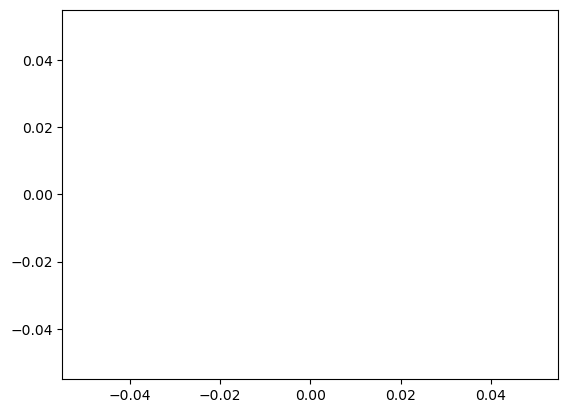

In [22]:
n_epoch = 0
loss_list = []
best_loss = 10000
save_file = os.path.join(opt.save_folder + 'models', 'last.pth')
#save_model(model, optimizer, opt, opt.epochs, save_file)

for epoch in range(1, n_epoch + 1):
    loss = train_ss(Net,projection_head,unlabelled_train_loader, epoch)
    print(f'Epoch {epoch:3d}, Loss: {loss:.4f}')
    scheduler.step()
    loss_list.append(loss)
    if loss<best_loss:
        best_loss = loss
        #torch.save(Net, f'./model_checkpoints/simclr_ki67/resnet50_ki67_dapi_chan_pretraining_best_loss.pth.tar') 
        save_model(Net, optimizer, opt, opt.epochs, '/kaggle/working/unsupervised/best_loss.pth')
    elif epoch % 10 == 0:
        #best_loss = loss
        #torch.save(Net, f'./model_checkpoints/simclr_ki67/resnet50_ki67_dapi_chan_pretraining_checkpoint.pth.tar') 
        save_model(Net, optimizer, opt, opt.epochs, f'/kaggle/working/unsupervised/epoch{epoch}.pth')
#torch.save(Net, f'./model_checkpoints/simclr_ki67/resnet50_ki67_dapi_chan_pretraining_final_checkpoint.pth.tar') 
plt.figure()
plt.plot(loss_list)

In [23]:
###### SUPERVISED LEARNING PART

In [24]:
# If loading pretrained
load_file = "/kaggle/input/models/epoch30_changing.pth"  # change to model path
device = torch.device("cuda:0" )
Net = Encdr().to(device)
Net = load_model(Net, load_file, "net")

==> Loading...


In [25]:
#Net.add_feature()
model, criterion = set_model_st(opt, Net)    
optimizer = set_optimizer(opt, model)

In [26]:
# To check performance without the pre training
#model, criterion = set_model(opt)    
#optimizer = set_optimizer(opt, model)

In [27]:
# training routine with freezing
model[0].requires_grad_(False)
opt.learning_rate = 0.05

best_f1 = 0.6
for epoch in range(1, 0+1):
    train_supervised(train_loader, val_loader, model, criterion, optimizer, epoch, opt)
    cur_f1 = sample_evaluation(val_loader, model, opt)
    if cur_f1 > best_f1:
        best_f1 = cur_f1
        submission_generate(test_loader, model, opt, epoch)
    elif epoch % 10 == 0:
        submission_generate(test_loader, model, opt, epoch)

In [28]:
# training routine without freezing
model[0].requires_grad_(True)
opt.learning_rate = 0.001

best_f1 = 0.5
for epoch in range(1, 81):
    train_supervised(train_loader, val_loader, model, criterion, optimizer, epoch, opt)
    cur_f1 = sample_evaluation(val_loader, model, opt)
    if cur_f1 > best_f1:
        best_f1 = cur_f1
        submission_generate(test_loader, model, opt, epoch)
    if epoch % 10 == 0:
        submission_generate(test_loader, model, opt, epoch)
    

Train: [1][10/140]	
Train: [1][20/140]	
Train: [1][30/140]	
Train: [1][40/140]	
Train: [1][50/140]	
Train: [1][60/140]	
Train: [1][70/140]	
Train: [1][80/140]	
Train: [1][90/140]	
Train: [1][100/140]	
Train: [1][110/140]	
Train: [1][120/140]	
Train: [1][130/140]	
Train: [1][140/140]	
Training Accuracy: 71.12%
Training loss: 0.5470158385906981
Validation accuracy: 68.06122448979592 %
Validation F1: 0.19807576202173652


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [2][10/140]	
Train: [2][20/140]	
Train: [2][30/140]	
Train: [2][40/140]	
Train: [2][50/140]	
Train: [2][60/140]	
Train: [2][70/140]	
Train: [2][80/140]	
Train: [2][90/140]	
Train: [2][100/140]	
Train: [2][110/140]	
Train: [2][120/140]	
Train: [2][130/140]	
Train: [2][140/140]	
Training Accuracy: 78.08%
Training loss: 0.450437026578339
Validation accuracy: 69.21768707482994 %
Validation F1: 0.43181567809858507


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [3][10/140]	
Train: [3][20/140]	
Train: [3][30/140]	
Train: [3][40/140]	
Train: [3][50/140]	
Train: [3][60/140]	
Train: [3][70/140]	
Train: [3][80/140]	
Train: [3][90/140]	
Train: [3][100/140]	
Train: [3][110/140]	
Train: [3][120/140]	
Train: [3][130/140]	
Train: [3][140/140]	
Training Accuracy: 80.55%
Training loss: 0.4109656302871178
Validation accuracy: 73.26530612244898 %
Validation F1: 0.424996707185191


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [4][10/140]	
Train: [4][20/140]	
Train: [4][30/140]	
Train: [4][40/140]	
Train: [4][50/140]	
Train: [4][60/140]	
Train: [4][70/140]	
Train: [4][80/140]	
Train: [4][90/140]	
Train: [4][100/140]	
Train: [4][110/140]	
Train: [4][120/140]	
Train: [4][130/140]	
Train: [4][140/140]	
Training Accuracy: 81.76%
Training loss: 0.3890121982460681
Validation accuracy: 74.14965986394559 %
Validation F1: 0.4670866000428302


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [5][10/140]	
Train: [5][20/140]	
Train: [5][30/140]	
Train: [5][40/140]	
Train: [5][50/140]	
Train: [5][60/140]	
Train: [5][70/140]	
Train: [5][80/140]	
Train: [5][90/140]	
Train: [5][100/140]	
Train: [5][110/140]	
Train: [5][120/140]	
Train: [5][130/140]	
Train: [5][140/140]	
Training Accuracy: 82.87%
Training loss: 0.37227338630005125
Validation accuracy: 74.96598639455783 %
Validation F1: 0.4682095075026384


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [6][10/140]	
Train: [6][20/140]	
Train: [6][30/140]	
Train: [6][40/140]	
Train: [6][50/140]	
Train: [6][60/140]	
Train: [6][70/140]	
Train: [6][80/140]	
Train: [6][90/140]	
Train: [6][100/140]	
Train: [6][110/140]	
Train: [6][120/140]	
Train: [6][130/140]	
Train: [6][140/140]	
Training Accuracy: 83.49%
Training loss: 0.36033413604145814
Validation accuracy: 76.59863945578232 %
Validation F1: 0.4967647090390965


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [7][10/140]	
Train: [7][20/140]	
Train: [7][30/140]	
Train: [7][40/140]	
Train: [7][50/140]	
Train: [7][60/140]	
Train: [7][70/140]	
Train: [7][80/140]	
Train: [7][90/140]	
Train: [7][100/140]	
Train: [7][110/140]	
Train: [7][120/140]	
Train: [7][130/140]	
Train: [7][140/140]	
Training Accuracy: 84.17%
Training loss: 0.34669277583919156
Validation accuracy: 76.0204081632653 %
Validation F1: 0.4592641092616779


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [8][10/140]	
Train: [8][20/140]	
Train: [8][30/140]	
Train: [8][40/140]	
Train: [8][50/140]	
Train: [8][60/140]	
Train: [8][70/140]	
Train: [8][80/140]	
Train: [8][90/140]	
Train: [8][100/140]	
Train: [8][110/140]	
Train: [8][120/140]	
Train: [8][130/140]	
Train: [8][140/140]	
Training Accuracy: 84.55%
Training loss: 0.3418175293929268
Validation accuracy: 73.70748299319729 %
Validation F1: 0.44811442881454383


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [9][10/140]	
Train: [9][20/140]	
Train: [9][30/140]	
Train: [9][40/140]	
Train: [9][50/140]	
Train: [9][60/140]	
Train: [9][70/140]	
Train: [9][80/140]	
Train: [9][90/140]	
Train: [9][100/140]	
Train: [9][110/140]	
Train: [9][120/140]	
Train: [9][130/140]	
Train: [9][140/140]	
Training Accuracy: 84.89%
Training loss: 0.3311761933662721
Validation accuracy: 77.48299319727892 %
Validation F1: 0.5027158945962064


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [10][10/140]	
Train: [10][20/140]	
Train: [10][30/140]	
Train: [10][40/140]	
Train: [10][50/140]	
Train: [10][60/140]	
Train: [10][70/140]	
Train: [10][80/140]	
Train: [10][90/140]	
Train: [10][100/140]	
Train: [10][110/140]	
Train: [10][120/140]	
Train: [10][130/140]	
Train: [10][140/140]	
Training Accuracy: 85.84%
Training loss: 0.3156056839619337
Validation accuracy: 74.72789115646259 %
Validation F1: 0.4793595126942516


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [11][10/140]	
Train: [11][20/140]	
Train: [11][30/140]	
Train: [11][40/140]	
Train: [11][50/140]	
Train: [11][60/140]	
Train: [11][70/140]	
Train: [11][80/140]	
Train: [11][90/140]	
Train: [11][100/140]	
Train: [11][110/140]	
Train: [11][120/140]	
Train: [11][130/140]	
Train: [11][140/140]	
Training Accuracy: 85.85%
Training loss: 0.3162682317623404
Validation accuracy: 73.87755102040816 %
Validation F1: 0.4545340887732838


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [12][10/140]	
Train: [12][20/140]	
Train: [12][30/140]	
Train: [12][40/140]	
Train: [12][50/140]	
Train: [12][60/140]	
Train: [12][70/140]	
Train: [12][80/140]	
Train: [12][90/140]	
Train: [12][100/140]	
Train: [12][110/140]	
Train: [12][120/140]	
Train: [12][130/140]	
Train: [12][140/140]	
Training Accuracy: 86.39%
Training loss: 0.3054400716469036
Validation accuracy: 74.62585034013605 %
Validation F1: 0.49298503539016963


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [13][10/140]	
Train: [13][20/140]	
Train: [13][30/140]	
Train: [13][40/140]	
Train: [13][50/140]	
Train: [13][60/140]	
Train: [13][70/140]	
Train: [13][80/140]	
Train: [13][90/140]	
Train: [13][100/140]	
Train: [13][110/140]	
Train: [13][120/140]	
Train: [13][130/140]	
Train: [13][140/140]	
Training Accuracy: 86.74%
Training loss: 0.3015335009260599
Validation accuracy: 77.82312925170068 %
Validation F1: 0.5792661836911249


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [14][10/140]	
Train: [14][20/140]	
Train: [14][30/140]	
Train: [14][40/140]	
Train: [14][50/140]	
Train: [14][60/140]	
Train: [14][70/140]	
Train: [14][80/140]	
Train: [14][90/140]	
Train: [14][100/140]	
Train: [14][110/140]	
Train: [14][120/140]	
Train: [14][130/140]	
Train: [14][140/140]	
Training Accuracy: 87.00%
Training loss: 0.2947095169109944
Validation accuracy: 78.80952380952381 %
Validation F1: 0.5680334955259033


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [15][10/140]	
Train: [15][20/140]	
Train: [15][30/140]	
Train: [15][40/140]	
Train: [15][50/140]	
Train: [15][60/140]	
Train: [15][70/140]	
Train: [15][80/140]	
Train: [15][90/140]	
Train: [15][100/140]	
Train: [15][110/140]	
Train: [15][120/140]	
Train: [15][130/140]	
Train: [15][140/140]	
Training Accuracy: 87.25%
Training loss: 0.291755621617459
Validation accuracy: 74.65986394557824 %
Validation F1: 0.5318333114439858


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [16][10/140]	
Train: [16][20/140]	
Train: [16][30/140]	
Train: [16][40/140]	
Train: [16][50/140]	
Train: [16][60/140]	
Train: [16][70/140]	
Train: [16][80/140]	
Train: [16][90/140]	
Train: [16][100/140]	
Train: [16][110/140]	
Train: [16][120/140]	
Train: [16][130/140]	
Train: [16][140/140]	
Training Accuracy: 87.46%
Training loss: 0.28302047596995833
Validation accuracy: 72.38095238095238 %
Validation F1: 0.46986691034239936


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [17][10/140]	
Train: [17][20/140]	
Train: [17][30/140]	
Train: [17][40/140]	
Train: [17][50/140]	
Train: [17][60/140]	
Train: [17][70/140]	
Train: [17][80/140]	
Train: [17][90/140]	
Train: [17][100/140]	
Train: [17][110/140]	
Train: [17][120/140]	
Train: [17][130/140]	
Train: [17][140/140]	
Training Accuracy: 87.81%
Training loss: 0.27902222018547723
Validation accuracy: 78.36734693877551 %
Validation F1: 0.6045969812932276


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [18][10/140]	
Train: [18][20/140]	
Train: [18][30/140]	
Train: [18][40/140]	
Train: [18][50/140]	
Train: [18][60/140]	
Train: [18][70/140]	
Train: [18][80/140]	
Train: [18][90/140]	
Train: [18][100/140]	
Train: [18][110/140]	
Train: [18][120/140]	
Train: [18][130/140]	
Train: [18][140/140]	
Training Accuracy: 88.27%
Training loss: 0.2695687993421873
Validation accuracy: 77.24489795918367 %
Validation F1: 0.5794515007786839


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [19][10/140]	
Train: [19][20/140]	
Train: [19][30/140]	
Train: [19][40/140]	
Train: [19][50/140]	
Train: [19][60/140]	
Train: [19][70/140]	
Train: [19][80/140]	
Train: [19][90/140]	
Train: [19][100/140]	
Train: [19][110/140]	
Train: [19][120/140]	
Train: [19][130/140]	
Train: [19][140/140]	
Training Accuracy: 88.08%
Training loss: 0.2708912130548003
Validation accuracy: 72.31292517006803 %
Validation F1: 0.54614001789575


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [20][10/140]	
Train: [20][20/140]	
Train: [20][30/140]	
Train: [20][40/140]	
Train: [20][50/140]	
Train: [20][60/140]	
Train: [20][70/140]	
Train: [20][80/140]	
Train: [20][90/140]	
Train: [20][100/140]	
Train: [20][110/140]	
Train: [20][120/140]	
Train: [20][130/140]	
Train: [20][140/140]	
Training Accuracy: 88.34%
Training loss: 0.26671171569655794
Validation accuracy: 77.27891156462586 %
Validation F1: 0.567632579354878


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [21][10/140]	
Train: [21][20/140]	
Train: [21][30/140]	
Train: [21][40/140]	
Train: [21][50/140]	
Train: [21][60/140]	
Train: [21][70/140]	
Train: [21][80/140]	
Train: [21][90/140]	
Train: [21][100/140]	
Train: [21][110/140]	
Train: [21][120/140]	
Train: [21][130/140]	
Train: [21][140/140]	
Training Accuracy: 88.82%
Training loss: 0.2607361055136957
Validation accuracy: 76.25850340136054 %
Validation F1: 0.459290226016025


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [22][10/140]	
Train: [22][20/140]	
Train: [22][30/140]	
Train: [22][40/140]	
Train: [22][50/140]	
Train: [22][60/140]	
Train: [22][70/140]	
Train: [22][80/140]	
Train: [22][90/140]	
Train: [22][100/140]	
Train: [22][110/140]	
Train: [22][120/140]	
Train: [22][130/140]	
Train: [22][140/140]	
Training Accuracy: 88.61%
Training loss: 0.26257337221090876
Validation accuracy: 77.27891156462586 %
Validation F1: 0.5529068228934956


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [23][10/140]	
Train: [23][20/140]	
Train: [23][30/140]	
Train: [23][40/140]	
Train: [23][50/140]	
Train: [23][60/140]	
Train: [23][70/140]	
Train: [23][80/140]	
Train: [23][90/140]	
Train: [23][100/140]	
Train: [23][110/140]	
Train: [23][120/140]	
Train: [23][130/140]	
Train: [23][140/140]	
Training Accuracy: 88.90%
Training loss: 0.25550965087567246
Validation accuracy: 78.70748299319727 %
Validation F1: 0.5603556015269476


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [24][10/140]	
Train: [24][20/140]	
Train: [24][30/140]	
Train: [24][40/140]	
Train: [24][50/140]	
Train: [24][60/140]	
Train: [24][70/140]	
Train: [24][80/140]	
Train: [24][90/140]	
Train: [24][100/140]	
Train: [24][110/140]	
Train: [24][120/140]	
Train: [24][130/140]	
Train: [24][140/140]	
Training Accuracy: 89.25%
Training loss: 0.2493532026100116
Validation accuracy: 80.23809523809524 %
Validation F1: 0.6151192321321196


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [25][10/140]	
Train: [25][20/140]	
Train: [25][30/140]	
Train: [25][40/140]	
Train: [25][50/140]	
Train: [25][60/140]	
Train: [25][70/140]	
Train: [25][80/140]	
Train: [25][90/140]	
Train: [25][100/140]	
Train: [25][110/140]	
Train: [25][120/140]	
Train: [25][130/140]	
Train: [25][140/140]	
Training Accuracy: 89.21%
Training loss: 0.250240393452485
Validation accuracy: 76.39455782312925 %
Validation F1: 0.48716257183476913


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [26][10/140]	
Train: [26][20/140]	
Train: [26][30/140]	
Train: [26][40/140]	
Train: [26][50/140]	
Train: [26][60/140]	
Train: [26][70/140]	
Train: [26][80/140]	
Train: [26][90/140]	
Train: [26][100/140]	
Train: [26][110/140]	
Train: [26][120/140]	
Train: [26][130/140]	
Train: [26][140/140]	
Training Accuracy: 89.63%
Training loss: 0.24162423682202136
Validation accuracy: 79.59183673469387 %
Validation F1: 0.627371502907223


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [27][10/140]	
Train: [27][20/140]	
Train: [27][30/140]	
Train: [27][40/140]	
Train: [27][50/140]	
Train: [27][60/140]	
Train: [27][70/140]	
Train: [27][80/140]	
Train: [27][90/140]	
Train: [27][100/140]	
Train: [27][110/140]	
Train: [27][120/140]	
Train: [27][130/140]	
Train: [27][140/140]	
Training Accuracy: 89.55%
Training loss: 0.2399387460040736
Validation accuracy: 79.04761904761905 %
Validation F1: 0.5489246460610634


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [28][10/140]	
Train: [28][20/140]	
Train: [28][30/140]	
Train: [28][40/140]	
Train: [28][50/140]	
Train: [28][60/140]	
Train: [28][70/140]	
Train: [28][80/140]	
Train: [28][90/140]	
Train: [28][100/140]	
Train: [28][110/140]	
Train: [28][120/140]	
Train: [28][130/140]	
Train: [28][140/140]	
Training Accuracy: 89.83%
Training loss: 0.23642596142271705
Validation accuracy: 76.97278911564625 %
Validation F1: 0.5613223831180544


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [29][10/140]	
Train: [29][20/140]	
Train: [29][30/140]	
Train: [29][40/140]	
Train: [29][50/140]	
Train: [29][60/140]	
Train: [29][70/140]	
Train: [29][80/140]	
Train: [29][90/140]	
Train: [29][100/140]	
Train: [29][110/140]	
Train: [29][120/140]	
Train: [29][130/140]	
Train: [29][140/140]	
Training Accuracy: 90.28%
Training loss: 0.22979540814463667
Validation accuracy: 78.9795918367347 %
Validation F1: 0.5726044580252075


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [30][10/140]	
Train: [30][20/140]	
Train: [30][30/140]	
Train: [30][40/140]	
Train: [30][50/140]	
Train: [30][60/140]	
Train: [30][70/140]	
Train: [30][80/140]	
Train: [30][90/140]	
Train: [30][100/140]	
Train: [30][110/140]	
Train: [30][120/140]	
Train: [30][130/140]	
Train: [30][140/140]	
Training Accuracy: 90.13%
Training loss: 0.23037089799439114
Validation accuracy: 76.93877551020408 %
Validation F1: 0.5725687344686223


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [31][10/140]	
Train: [31][20/140]	
Train: [31][30/140]	
Train: [31][40/140]	
Train: [31][50/140]	
Train: [31][60/140]	
Train: [31][70/140]	
Train: [31][80/140]	
Train: [31][90/140]	
Train: [31][100/140]	
Train: [31][110/140]	
Train: [31][120/140]	
Train: [31][130/140]	
Train: [31][140/140]	
Training Accuracy: 90.20%
Training loss: 0.2303076014073073
Validation accuracy: 79.25170068027211 %
Validation F1: 0.5438959181380484


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [32][10/140]	
Train: [32][20/140]	
Train: [32][30/140]	
Train: [32][40/140]	
Train: [32][50/140]	
Train: [32][60/140]	
Train: [32][70/140]	
Train: [32][80/140]	
Train: [32][90/140]	
Train: [32][100/140]	
Train: [32][110/140]	
Train: [32][120/140]	
Train: [32][130/140]	
Train: [32][140/140]	
Training Accuracy: 90.37%
Training loss: 0.22586918747740548
Validation accuracy: 75.0 %
Validation F1: 0.5490046816583747


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [33][10/140]	
Train: [33][20/140]	
Train: [33][30/140]	
Train: [33][40/140]	
Train: [33][50/140]	
Train: [33][60/140]	
Train: [33][70/140]	
Train: [33][80/140]	
Train: [33][90/140]	
Train: [33][100/140]	
Train: [33][110/140]	
Train: [33][120/140]	
Train: [33][130/140]	
Train: [33][140/140]	
Training Accuracy: 90.46%
Training loss: 0.22577178091592762
Validation accuracy: 79.72789115646258 %
Validation F1: 0.6332990773832284


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [34][10/140]	
Train: [34][20/140]	
Train: [34][30/140]	
Train: [34][40/140]	
Train: [34][50/140]	
Train: [34][60/140]	
Train: [34][70/140]	
Train: [34][80/140]	
Train: [34][90/140]	
Train: [34][100/140]	
Train: [34][110/140]	
Train: [34][120/140]	
Train: [34][130/140]	
Train: [34][140/140]	
Training Accuracy: 90.63%
Training loss: 0.22093397828395872
Validation accuracy: 79.62585034013605 %
Validation F1: 0.6058627489675136


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [35][10/140]	
Train: [35][20/140]	
Train: [35][30/140]	
Train: [35][40/140]	
Train: [35][50/140]	
Train: [35][60/140]	
Train: [35][70/140]	
Train: [35][80/140]	
Train: [35][90/140]	
Train: [35][100/140]	
Train: [35][110/140]	
Train: [35][120/140]	
Train: [35][130/140]	
Train: [35][140/140]	
Training Accuracy: 90.60%
Training loss: 0.2219404056751827
Validation accuracy: 78.77551020408163 %
Validation F1: 0.5909323158670836


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [36][10/140]	
Train: [36][20/140]	
Train: [36][30/140]	
Train: [36][40/140]	
Train: [36][50/140]	
Train: [36][60/140]	
Train: [36][70/140]	
Train: [36][80/140]	
Train: [36][90/140]	
Train: [36][100/140]	
Train: [36][110/140]	
Train: [36][120/140]	
Train: [36][130/140]	
Train: [36][140/140]	
Training Accuracy: 90.82%
Training loss: 0.21380728351198308
Validation accuracy: 81.36054421768706 %
Validation F1: 0.6101036541455217


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [37][10/140]	
Train: [37][20/140]	
Train: [37][30/140]	
Train: [37][40/140]	
Train: [37][50/140]	
Train: [37][60/140]	
Train: [37][70/140]	
Train: [37][80/140]	
Train: [37][90/140]	
Train: [37][100/140]	
Train: [37][110/140]	
Train: [37][120/140]	
Train: [37][130/140]	
Train: [37][140/140]	
Training Accuracy: 90.89%
Training loss: 0.2154258839196222
Validation accuracy: 77.55102040816327 %
Validation F1: 0.516055882636155


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [38][10/140]	
Train: [38][20/140]	
Train: [38][30/140]	
Train: [38][40/140]	
Train: [38][50/140]	
Train: [38][60/140]	
Train: [38][70/140]	
Train: [38][80/140]	
Train: [38][90/140]	
Train: [38][100/140]	
Train: [38][110/140]	
Train: [38][120/140]	
Train: [38][130/140]	
Train: [38][140/140]	
Training Accuracy: 91.04%
Training loss: 0.20987470264885558
Validation accuracy: 78.77551020408163 %
Validation F1: 0.5840535208664424


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [39][10/140]	
Train: [39][20/140]	
Train: [39][30/140]	
Train: [39][40/140]	
Train: [39][50/140]	
Train: [39][60/140]	
Train: [39][70/140]	
Train: [39][80/140]	
Train: [39][90/140]	
Train: [39][100/140]	
Train: [39][110/140]	
Train: [39][120/140]	
Train: [39][130/140]	
Train: [39][140/140]	
Training Accuracy: 91.05%
Training loss: 0.21300757162558656
Validation accuracy: 80.20408163265306 %
Validation F1: 0.5848661661862188


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [40][10/140]	
Train: [40][20/140]	
Train: [40][30/140]	
Train: [40][40/140]	
Train: [40][50/140]	
Train: [40][60/140]	
Train: [40][70/140]	
Train: [40][80/140]	
Train: [40][90/140]	
Train: [40][100/140]	
Train: [40][110/140]	
Train: [40][120/140]	
Train: [40][130/140]	
Train: [40][140/140]	
Training Accuracy: 90.96%
Training loss: 0.2109233014090068
Validation accuracy: 78.63945578231292 %
Validation F1: 0.5954691864914113


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [41][10/140]	
Train: [41][20/140]	
Train: [41][30/140]	
Train: [41][40/140]	
Train: [41][50/140]	
Train: [41][60/140]	
Train: [41][70/140]	
Train: [41][80/140]	
Train: [41][90/140]	
Train: [41][100/140]	
Train: [41][110/140]	
Train: [41][120/140]	
Train: [41][130/140]	
Train: [41][140/140]	
Training Accuracy: 91.44%
Training loss: 0.2052356945570073
Validation accuracy: 77.7891156462585 %
Validation F1: 0.5599281529142816


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [42][10/140]	
Train: [42][20/140]	
Train: [42][30/140]	
Train: [42][40/140]	
Train: [42][50/140]	
Train: [42][60/140]	
Train: [42][70/140]	
Train: [42][80/140]	
Train: [42][90/140]	
Train: [42][100/140]	
Train: [42][110/140]	
Train: [42][120/140]	
Train: [42][130/140]	
Train: [42][140/140]	
Training Accuracy: 91.36%
Training loss: 0.20557445207166683
Validation accuracy: 81.83673469387756 %
Validation F1: 0.6201479006947294


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [43][10/140]	
Train: [43][20/140]	
Train: [43][30/140]	
Train: [43][40/140]	
Train: [43][50/140]	
Train: [43][60/140]	
Train: [43][70/140]	
Train: [43][80/140]	
Train: [43][90/140]	
Train: [43][100/140]	
Train: [43][110/140]	
Train: [43][120/140]	
Train: [43][130/140]	
Train: [43][140/140]	
Training Accuracy: 91.45%
Training loss: 0.20262255506428348
Validation accuracy: 79.6938775510204 %
Validation F1: 0.565564573584802


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [44][10/140]	
Train: [44][20/140]	
Train: [44][30/140]	
Train: [44][40/140]	
Train: [44][50/140]	
Train: [44][60/140]	
Train: [44][70/140]	
Train: [44][80/140]	
Train: [44][90/140]	
Train: [44][100/140]	
Train: [44][110/140]	
Train: [44][120/140]	
Train: [44][130/140]	
Train: [44][140/140]	
Training Accuracy: 91.49%
Training loss: 0.199176706438857
Validation accuracy: 78.74149659863946 %
Validation F1: 0.5866673259629596


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [45][10/140]	
Train: [45][20/140]	
Train: [45][30/140]	
Train: [45][40/140]	
Train: [45][50/140]	
Train: [45][60/140]	
Train: [45][70/140]	
Train: [45][80/140]	
Train: [45][90/140]	
Train: [45][100/140]	
Train: [45][110/140]	
Train: [45][120/140]	
Train: [45][130/140]	
Train: [45][140/140]	
Training Accuracy: 91.67%
Training loss: 0.19844538399151393
Validation accuracy: 77.27891156462586 %
Validation F1: 0.5836675985722642


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [46][10/140]	
Train: [46][20/140]	
Train: [46][30/140]	
Train: [46][40/140]	
Train: [46][50/140]	
Train: [46][60/140]	
Train: [46][70/140]	
Train: [46][80/140]	
Train: [46][90/140]	
Train: [46][100/140]	
Train: [46][110/140]	
Train: [46][120/140]	
Train: [46][130/140]	
Train: [46][140/140]	
Training Accuracy: 91.65%
Training loss: 0.1977403190711283
Validation accuracy: 80.03401360544218 %
Validation F1: 0.6241956387563287


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [47][10/140]	
Train: [47][20/140]	
Train: [47][30/140]	
Train: [47][40/140]	
Train: [47][50/140]	
Train: [47][60/140]	
Train: [47][70/140]	
Train: [47][80/140]	
Train: [47][90/140]	
Train: [47][100/140]	
Train: [47][110/140]	
Train: [47][120/140]	
Train: [47][130/140]	
Train: [47][140/140]	
Training Accuracy: 91.72%
Training loss: 0.19788958052063393
Validation accuracy: 81.3265306122449 %
Validation F1: 0.5998076541909375


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [48][10/140]	
Train: [48][20/140]	
Train: [48][30/140]	
Train: [48][40/140]	
Train: [48][50/140]	
Train: [48][60/140]	
Train: [48][70/140]	
Train: [48][80/140]	
Train: [48][90/140]	
Train: [48][100/140]	
Train: [48][110/140]	
Train: [48][120/140]	
Train: [48][130/140]	
Train: [48][140/140]	
Training Accuracy: 91.86%
Training loss: 0.19438644587646073
Validation accuracy: 80.54421768707482 %
Validation F1: 0.5896617822328364


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [49][10/140]	
Train: [49][20/140]	
Train: [49][30/140]	
Train: [49][40/140]	
Train: [49][50/140]	
Train: [49][60/140]	
Train: [49][70/140]	
Train: [49][80/140]	
Train: [49][90/140]	
Train: [49][100/140]	
Train: [49][110/140]	
Train: [49][120/140]	
Train: [49][130/140]	
Train: [49][140/140]	
Training Accuracy: 92.05%
Training loss: 0.19462329736737613
Validation accuracy: 78.74149659863946 %
Validation F1: 0.5780386251983917


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [50][10/140]	
Train: [50][20/140]	
Train: [50][30/140]	
Train: [50][40/140]	
Train: [50][50/140]	
Train: [50][60/140]	
Train: [50][70/140]	
Train: [50][80/140]	
Train: [50][90/140]	
Train: [50][100/140]	
Train: [50][110/140]	
Train: [50][120/140]	
Train: [50][130/140]	
Train: [50][140/140]	
Training Accuracy: 91.99%
Training loss: 0.19030324028302373
Validation accuracy: 80.47619047619048 %
Validation F1: 0.5904151376193466


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [51][10/140]	
Train: [51][20/140]	
Train: [51][30/140]	
Train: [51][40/140]	
Train: [51][50/140]	
Train: [51][60/140]	
Train: [51][70/140]	
Train: [51][80/140]	
Train: [51][90/140]	
Train: [51][100/140]	
Train: [51][110/140]	
Train: [51][120/140]	
Train: [51][130/140]	
Train: [51][140/140]	
Training Accuracy: 91.88%
Training loss: 0.19306280934963024
Validation accuracy: 80.71428571428572 %
Validation F1: 0.617559352364669


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [52][10/140]	
Train: [52][20/140]	
Train: [52][30/140]	
Train: [52][40/140]	
Train: [52][50/140]	
Train: [52][60/140]	
Train: [52][70/140]	
Train: [52][80/140]	
Train: [52][90/140]	
Train: [52][100/140]	
Train: [52][110/140]	
Train: [52][120/140]	
Train: [52][130/140]	
Train: [52][140/140]	
Training Accuracy: 92.13%
Training loss: 0.18511046157754252
Validation accuracy: 80.47619047619048 %
Validation F1: 0.5798299782184969


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [53][10/140]	
Train: [53][20/140]	
Train: [53][30/140]	
Train: [53][40/140]	
Train: [53][50/140]	
Train: [53][60/140]	
Train: [53][70/140]	
Train: [53][80/140]	
Train: [53][90/140]	
Train: [53][100/140]	
Train: [53][110/140]	
Train: [53][120/140]	
Train: [53][130/140]	
Train: [53][140/140]	
Training Accuracy: 92.04%
Training loss: 0.19006740984413542
Validation accuracy: 79.35374149659864 %
Validation F1: 0.5893950980990627


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [54][10/140]	
Train: [54][20/140]	
Train: [54][30/140]	
Train: [54][40/140]	
Train: [54][50/140]	
Train: [54][60/140]	
Train: [54][70/140]	
Train: [54][80/140]	
Train: [54][90/140]	
Train: [54][100/140]	
Train: [54][110/140]	
Train: [54][120/140]	
Train: [54][130/140]	
Train: [54][140/140]	
Training Accuracy: 92.17%
Training loss: 0.1864017993378837
Validation accuracy: 81.9047619047619 %
Validation F1: 0.6333985389084542


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [55][10/140]	
Train: [55][20/140]	
Train: [55][30/140]	
Train: [55][40/140]	
Train: [55][50/140]	
Train: [55][60/140]	
Train: [55][70/140]	
Train: [55][80/140]	
Train: [55][90/140]	
Train: [55][100/140]	
Train: [55][110/140]	
Train: [55][120/140]	
Train: [55][130/140]	
Train: [55][140/140]	
Training Accuracy: 92.25%
Training loss: 0.18300199180500581
Validation accuracy: 78.9795918367347 %
Validation F1: 0.5448138471780826


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [56][10/140]	
Train: [56][20/140]	
Train: [56][30/140]	
Train: [56][40/140]	
Train: [56][50/140]	
Train: [56][60/140]	
Train: [56][70/140]	
Train: [56][80/140]	
Train: [56][90/140]	
Train: [56][100/140]	
Train: [56][110/140]	
Train: [56][120/140]	
Train: [56][130/140]	
Train: [56][140/140]	
Training Accuracy: 92.25%
Training loss: 0.18652375280041683
Validation accuracy: 80.81632653061224 %
Validation F1: 0.5642175634830378


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [57][10/140]	
Train: [57][20/140]	
Train: [57][30/140]	
Train: [57][40/140]	
Train: [57][50/140]	
Train: [57][60/140]	
Train: [57][70/140]	
Train: [57][80/140]	
Train: [57][90/140]	
Train: [57][100/140]	
Train: [57][110/140]	
Train: [57][120/140]	
Train: [57][130/140]	
Train: [57][140/140]	
Training Accuracy: 92.23%
Training loss: 0.1841966715140256
Validation accuracy: 80.64625850340136 %
Validation F1: 0.6139725703857479


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [58][10/140]	
Train: [58][20/140]	
Train: [58][30/140]	
Train: [58][40/140]	
Train: [58][50/140]	
Train: [58][60/140]	
Train: [58][70/140]	
Train: [58][80/140]	
Train: [58][90/140]	
Train: [58][100/140]	
Train: [58][110/140]	
Train: [58][120/140]	
Train: [58][130/140]	
Train: [58][140/140]	
Training Accuracy: 92.46%
Training loss: 0.17998738591915345
Validation accuracy: 80.54421768707482 %
Validation F1: 0.6079692423345779


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [59][10/140]	
Train: [59][20/140]	
Train: [59][30/140]	
Train: [59][40/140]	
Train: [59][50/140]	
Train: [59][60/140]	
Train: [59][70/140]	
Train: [59][80/140]	
Train: [59][90/140]	
Train: [59][100/140]	
Train: [59][110/140]	
Train: [59][120/140]	
Train: [59][130/140]	
Train: [59][140/140]	
Training Accuracy: 92.50%
Training loss: 0.176622422039843
Validation accuracy: 78.2312925170068 %
Validation F1: 0.5968342566559973


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [60][10/140]	
Train: [60][20/140]	
Train: [60][30/140]	
Train: [60][40/140]	
Train: [60][50/140]	
Train: [60][60/140]	
Train: [60][70/140]	
Train: [60][80/140]	
Train: [60][90/140]	
Train: [60][100/140]	
Train: [60][110/140]	
Train: [60][120/140]	
Train: [60][130/140]	
Train: [60][140/140]	
Training Accuracy: 92.55%
Training loss: 0.1759524994311939
Validation accuracy: 80.78231292517006 %
Validation F1: 0.6206944742656796


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [61][10/140]	
Train: [61][20/140]	
Train: [61][30/140]	
Train: [61][40/140]	
Train: [61][50/140]	
Train: [61][60/140]	
Train: [61][70/140]	
Train: [61][80/140]	
Train: [61][90/140]	
Train: [61][100/140]	
Train: [61][110/140]	
Train: [61][120/140]	
Train: [61][130/140]	
Train: [61][140/140]	
Training Accuracy: 92.49%
Training loss: 0.17990271620457418
Validation accuracy: 79.35374149659864 %
Validation F1: 0.577281529876946


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [62][10/140]	
Train: [62][20/140]	
Train: [62][30/140]	
Train: [62][40/140]	
Train: [62][50/140]	
Train: [62][60/140]	
Train: [62][70/140]	
Train: [62][80/140]	
Train: [62][90/140]	
Train: [62][100/140]	
Train: [62][110/140]	
Train: [62][120/140]	
Train: [62][130/140]	
Train: [62][140/140]	
Training Accuracy: 92.75%
Training loss: 0.17262305616062568
Validation accuracy: 81.15646258503402 %
Validation F1: 0.6179508289578929


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [63][10/140]	
Train: [63][20/140]	
Train: [63][30/140]	
Train: [63][40/140]	
Train: [63][50/140]	
Train: [63][60/140]	
Train: [63][70/140]	
Train: [63][80/140]	
Train: [63][90/140]	
Train: [63][100/140]	
Train: [63][110/140]	
Train: [63][120/140]	
Train: [63][130/140]	
Train: [63][140/140]	
Training Accuracy: 92.53%
Training loss: 0.17649366174091216
Validation accuracy: 77.72108843537416 %
Validation F1: 0.5439630453810721


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [64][10/140]	
Train: [64][20/140]	
Train: [64][30/140]	
Train: [64][40/140]	
Train: [64][50/140]	
Train: [64][60/140]	
Train: [64][70/140]	
Train: [64][80/140]	
Train: [64][90/140]	
Train: [64][100/140]	
Train: [64][110/140]	
Train: [64][120/140]	
Train: [64][130/140]	
Train: [64][140/140]	
Training Accuracy: 92.74%
Training loss: 0.17327564644971272
Validation accuracy: 78.87755102040816 %
Validation F1: 0.5589525609601634


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [65][10/140]	
Train: [65][20/140]	
Train: [65][30/140]	
Train: [65][40/140]	
Train: [65][50/140]	
Train: [65][60/140]	
Train: [65][70/140]	
Train: [65][80/140]	
Train: [65][90/140]	
Train: [65][100/140]	
Train: [65][110/140]	
Train: [65][120/140]	
Train: [65][130/140]	
Train: [65][140/140]	
Training Accuracy: 93.01%
Training loss: 0.17188881984284224
Validation accuracy: 81.08843537414965 %
Validation F1: 0.5847372460718644


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [66][10/140]	
Train: [66][20/140]	
Train: [66][30/140]	
Train: [66][40/140]	
Train: [66][50/140]	
Train: [66][60/140]	
Train: [66][70/140]	
Train: [66][80/140]	
Train: [66][90/140]	
Train: [66][100/140]	
Train: [66][110/140]	
Train: [66][120/140]	
Train: [66][130/140]	
Train: [66][140/140]	
Training Accuracy: 92.81%
Training loss: 0.17048063786020726
Validation accuracy: 82.44897959183673 %
Validation F1: 0.6230754935455812


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [67][10/140]	
Train: [67][20/140]	
Train: [67][30/140]	
Train: [67][40/140]	
Train: [67][50/140]	
Train: [67][60/140]	
Train: [67][70/140]	
Train: [67][80/140]	
Train: [67][90/140]	
Train: [67][100/140]	
Train: [67][110/140]	
Train: [67][120/140]	
Train: [67][130/140]	
Train: [67][140/140]	
Training Accuracy: 92.63%
Training loss: 0.1748346937868354
Validation accuracy: 79.08163265306123 %
Validation F1: 0.5986570759641704


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [68][10/140]	
Train: [68][20/140]	
Train: [68][30/140]	
Train: [68][40/140]	
Train: [68][50/140]	
Train: [68][60/140]	
Train: [68][70/140]	
Train: [68][80/140]	
Train: [68][90/140]	
Train: [68][100/140]	
Train: [68][110/140]	
Train: [68][120/140]	
Train: [68][130/140]	
Train: [68][140/140]	
Training Accuracy: 92.92%
Training loss: 0.1671315905965746
Validation accuracy: 80.17006802721089 %
Validation F1: 0.6003774614127658


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [69][10/140]	
Train: [69][20/140]	
Train: [69][30/140]	
Train: [69][40/140]	
Train: [69][50/140]	
Train: [69][60/140]	
Train: [69][70/140]	
Train: [69][80/140]	
Train: [69][90/140]	
Train: [69][100/140]	
Train: [69][110/140]	
Train: [69][120/140]	
Train: [69][130/140]	
Train: [69][140/140]	
Training Accuracy: 93.03%
Training loss: 0.1693831222555006
Validation accuracy: 77.89115646258503 %
Validation F1: 0.5796923357697862


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [70][10/140]	
Train: [70][20/140]	
Train: [70][30/140]	
Train: [70][40/140]	
Train: [70][50/140]	
Train: [70][60/140]	
Train: [70][70/140]	
Train: [70][80/140]	
Train: [70][90/140]	
Train: [70][100/140]	
Train: [70][110/140]	
Train: [70][120/140]	
Train: [70][130/140]	
Train: [70][140/140]	
Training Accuracy: 93.03%
Training loss: 0.16836387671598754
Validation accuracy: 77.10884353741496 %
Validation F1: 0.5274149378029375


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [71][10/140]	
Train: [71][20/140]	
Train: [71][30/140]	
Train: [71][40/140]	
Train: [71][50/140]	
Train: [71][60/140]	
Train: [71][70/140]	
Train: [71][80/140]	
Train: [71][90/140]	
Train: [71][100/140]	
Train: [71][110/140]	
Train: [71][120/140]	
Train: [71][130/140]	
Train: [71][140/140]	
Training Accuracy: 93.14%
Training loss: 0.1654956615787901
Validation accuracy: 81.12244897959184 %
Validation F1: 0.6300173004851619


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [72][10/140]	
Train: [72][20/140]	
Train: [72][30/140]	
Train: [72][40/140]	
Train: [72][50/140]	
Train: [72][60/140]	
Train: [72][70/140]	
Train: [72][80/140]	
Train: [72][90/140]	
Train: [72][100/140]	
Train: [72][110/140]	
Train: [72][120/140]	
Train: [72][130/140]	
Train: [72][140/140]	
Training Accuracy: 93.10%
Training loss: 0.1679847508294616
Validation accuracy: 80.06802721088435 %
Validation F1: 0.5967047672100508


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [73][10/140]	
Train: [73][20/140]	
Train: [73][30/140]	
Train: [73][40/140]	
Train: [73][50/140]	
Train: [73][60/140]	
Train: [73][70/140]	
Train: [73][80/140]	
Train: [73][90/140]	
Train: [73][100/140]	
Train: [73][110/140]	
Train: [73][120/140]	
Train: [73][130/140]	
Train: [73][140/140]	
Training Accuracy: 93.22%
Training loss: 0.16314203505506428
Validation accuracy: 82.0408163265306 %
Validation F1: 0.6164420016450415


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [74][10/140]	
Train: [74][20/140]	
Train: [74][30/140]	
Train: [74][40/140]	
Train: [74][50/140]	
Train: [74][60/140]	
Train: [74][70/140]	
Train: [74][80/140]	
Train: [74][90/140]	
Train: [74][100/140]	
Train: [74][110/140]	
Train: [74][120/140]	
Train: [74][130/140]	
Train: [74][140/140]	
Training Accuracy: 93.24%
Training loss: 0.1644249767011579
Validation accuracy: 79.1156462585034 %
Validation F1: 0.5679731331917285


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [75][10/140]	
Train: [75][20/140]	
Train: [75][30/140]	
Train: [75][40/140]	
Train: [75][50/140]	
Train: [75][60/140]	
Train: [75][70/140]	
Train: [75][80/140]	
Train: [75][90/140]	
Train: [75][100/140]	
Train: [75][110/140]	
Train: [75][120/140]	
Train: [75][130/140]	
Train: [75][140/140]	
Training Accuracy: 93.16%
Training loss: 0.16497063664851047
Validation accuracy: 77.99319727891157 %
Validation F1: 0.5736211036453043


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [76][10/140]	
Train: [76][20/140]	
Train: [76][30/140]	
Train: [76][40/140]	
Train: [76][50/140]	
Train: [76][60/140]	
Train: [76][70/140]	
Train: [76][80/140]	
Train: [76][90/140]	
Train: [76][100/140]	
Train: [76][110/140]	
Train: [76][120/140]	
Train: [76][130/140]	
Train: [76][140/140]	
Training Accuracy: 93.33%
Training loss: 0.16286876211187234
Validation accuracy: 78.46938775510203 %
Validation F1: 0.5731946413808964


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [77][10/140]	
Train: [77][20/140]	
Train: [77][30/140]	
Train: [77][40/140]	
Train: [77][50/140]	
Train: [77][60/140]	
Train: [77][70/140]	
Train: [77][80/140]	
Train: [77][90/140]	
Train: [77][100/140]	
Train: [77][110/140]	
Train: [77][120/140]	
Train: [77][130/140]	
Train: [77][140/140]	
Training Accuracy: 93.31%
Training loss: 0.16137041159878132
Validation accuracy: 76.7687074829932 %
Validation F1: 0.556453872156266


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [78][10/140]	
Train: [78][20/140]	
Train: [78][30/140]	
Train: [78][40/140]	
Train: [78][50/140]	
Train: [78][60/140]	
Train: [78][70/140]	
Train: [78][80/140]	
Train: [78][90/140]	
Train: [78][100/140]	
Train: [78][110/140]	
Train: [78][120/140]	
Train: [78][130/140]	
Train: [78][140/140]	
Training Accuracy: 93.18%
Training loss: 0.16195058682943894
Validation accuracy: 77.7891156462585 %
Validation F1: 0.5899594361698363


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [79][10/140]	
Train: [79][20/140]	
Train: [79][30/140]	
Train: [79][40/140]	
Train: [79][50/140]	
Train: [79][60/140]	
Train: [79][70/140]	
Train: [79][80/140]	
Train: [79][90/140]	
Train: [79][100/140]	
Train: [79][110/140]	
Train: [79][120/140]	
Train: [79][130/140]	
Train: [79][140/140]	
Training Accuracy: 93.40%
Training loss: 0.16040515579846334
Validation accuracy: 80.34013605442178 %
Validation F1: 0.605316262875189


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [80][10/140]	
Train: [80][20/140]	
Train: [80][30/140]	
Train: [80][40/140]	
Train: [80][50/140]	
Train: [80][60/140]	
Train: [80][70/140]	
Train: [80][80/140]	
Train: [80][90/140]	
Train: [80][100/140]	
Train: [80][110/140]	
Train: [80][120/140]	
Train: [80][130/140]	
Train: [80][140/140]	
Training Accuracy: 93.25%
Training loss: 0.16083118422439371
Validation accuracy: 81.42857142857143 %
Validation F1: 0.6087230586346773


In [29]:
save_file = os.path.join('/kaggle/working/supervised/last.pth')
save_model(model, optimizer, opt, opt.epochs, save_file)

==> Saving...


In [30]:
# Validation
sample_evaluation(val_loader, model, opt)

Validation accuracy: 81.42857142857143 %
Validation F1: 0.6087230586346773


0.6087230586346773

In [31]:
submission_generate(test_loader, model, opt)